# This is a work-in-progress notebook

We wish to know this:

1. How well does the model identify the correct number of senses for the target word?
2. **How well does the model identify the correct senses for the target word?**
3. **How well does the model assign the right words to a given sense of the target word?**
4. How well does the model assign the senses to the time intervals for the target word?

The script will evaluate **Q2** and **Q3**. Q4 will follow.

### Filenames of different model outputs must be different

In [460]:
# Basic variables and imports:

import codecs, csv, os, time, re, io
from os import listdir
from os.path import isfile, join
from  more_itertools import unique_everseen

# directories
dir_in = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "evaluation", "evaluation_input"))
dir_out = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "evaluation", "evaluation_output"))
dir_parameter = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "src", "dynamic-senses","greek_input","all_parameters"))


s_senses = io.open(dir_in+"/senses_69419.txt","r")
k_senses = io.open(dir_in+"/mus.dat","r")
parameter_file = io.open(dir_parameter+"/params_v1.txt","r")

target_id = os.path.basename(s_senses.name)
target_id = target_id.replace("senses_","")
target_id = target_id.replace(".txt","")
print("Target ID:",target_id)

param_name = os.path.basename(parameter_file.name)
param_name = param_name.replace("params","")


results_file = io.open(dir_out+"/"+target_id+param_name,"w")

# DEBUG:
#s_senses = io.open(dir_in+"/senses_69419_debug.txt","r")
#k_senses = io.open(dir_in+"/mus_debug.dat","r")
# k0 = mus4
# k1 = mus3
# k2 = mus2
# k3 = mus1
# k4 = nothing



file_senses = s_senses.readlines()[1:]
output_senses = k_senses.read()

i = 0
for line in parameter_file.readlines():
    i+=1
    if i == 4:
        line = line.split("\t")
        window_size = int(line[1])
        print("Window size:",window_size,type(window_size))
        
    if i == 13:
        line = line.split("\t")
        iterations = int(line[1])
        print("Iterations:",iterations,type(iterations))
        
    if i == 14:
        line = line.split("\t")
        start_time = int(line[1])
        print("Start time:",start_time,type(start_time))
        
    if i == 15:
        line = line.split("\t")
        end_time = int(line[1])
        print("End time:",end_time,type(end_time))
    
    if i == 16:
        line = line.split("\t")
        time_interval = int(line[1])
        print("Time interval:",time_interval,type(time_interval))

results_file.write("Target ID %s Window size %s Start time %s End time %s Time Interval %s Iterations %s\n" % (target_id,window_size,start_time,end_time,time_interval,iterations))

Target ID: 69419
Window size: 5 <class 'int'>
Iterations: 100 <class 'int'>
Start time: -430 <class 'int'>
End time: 359 <class 'int'>
Time interval: 100 <class 'int'>


92

In [461]:
# Defining time periods from the output file

total_years = end_time-start_time
perioddd = 0
temp_start_time = start_time

for year in range(temp_start_time,end_time):
    if temp_start_time + time_interval < end_time:
        perioddd +=1
        print(perioddd)
        temp_start_time += time_interval

number_of_slices = perioddd # cfr above

slice_duration = time_interval # read from the parameter file
print(slice_duration)

print(start_time,end_time)

slice_years = dict()

for period in range(0,number_of_slices):
    slice_years[period] = list()
    
    if period == number_of_slices-1:
        for i in range(latest_i,end_time):
            slice_years[period].append(i)  
    
    if period != number_of_slices-1:
        for i in range(start_time,end_time):
        
            if i > int(period*slice_duration) + start_time:
                if i < int((period+1)*slice_duration) + start_time:
                    slice_years[period].append(i)
                    latest_i = i
#print(slice_years)

1
2
3
4
5
6
7
100
-430 359


## TODO

- ~~create the notebook~~
- ~~organise the notebook~~
- ~~write "general idea" pseudocode for the evaluation~~
- ~~get input files~~
- ~~figure out data structures to store the variables~~
- ~~write actual code~~

## Q2: How well does the model identify the correct senses for the target word?

### Pseudocode 

In [462]:
# For each target word, we have a list of senses  s (given by the expert)
# For each target word, we have a list of senses k (given by the model)
# This Q consists in matching s and k, and doing so in a confident way --> confidence score

for each k:
    for each s:
        create conf(k,s)

# What is conf(k,s)?
        conf(k,s) = (p1*match(w1,s)+p2*match(w1,s)+px(wx,s))/10 WHERE
    
            px = probability of word wx 
                
                and
            
            match(wx,s) =   1/number_of_senses_assigned_to_wx if s_is_one_of_them 
            
                    or 
                            0 if w_is_not_associated_to_s
                
# Once we have gone through all s for one k, we have to choose the best k for s. How? (TBD, cfr Valerio and Barbara)

# Once all ks have been assigned to all ss (or NA), we can calculate a general confidence score for the model.
# One easy way to do that: 

conf_score_model = number_of_non_NA/k

SyntaxError: invalid syntax (<ipython-input-462-82fa54601c9a>, line 5)

### Real code

Steps:

- extract all senses from the file
- use those senses as keys for a dictionary, `dict_of_words`
- fill the dictionary: for each key, we store a list of words pertaining to that sense
- transform the lists as sets so as to remove duplicates within the same sense
- create a dictionary with a word as a key and its weight as a value, depending on how many senses it appears
- parse the model output and get the probability weights for each word
- do not take into account the first line
- take care of empty lines

Todo:



In [463]:
expert_senses = list() # list where we store all sense ids provided by expert
#sense_for_period_counter = 0




for line in file_senses: 
    cells = line.split("\t")
    sense = cells[11] # The sense ID is after the 10th tab
    if sense != 'w':
        
        
        if int(cells[12]) == 1:   ## we only take the senses annotated because of collocates and nothing else
            #print(int(s[12]))
            expert_senses.append(sense)
              
        else:
            expert_senses.append("NA") # if the reason for finding the sense is not "collocates" (1), the sense NA is created


#print(len(expert_senses),expert_senses,len(set(expert_senses)))


expert_senses_set = list(set(expert_senses)) # we only keep the unique senses
expert_senses = list(unique_everseen(expert_senses))
print("SET",expert_senses_set)
print("ITERTOOLS",expert_senses)

number_of_s = len(expert_senses)  # we create a variable that stores the number of unique senses
print("Number of senses:",number_of_s,expert_senses)

# This dictionary has a sense as a key, and a list of words as a value. 
dict_of_words = dict()
# This list stores all words
list_of_all_words = list()
# This dictionary stores all words as keys and their weight as value
word_weight = dict()
# This dictionary stores the number of times a sense appears in a slice
sense_date_amount = dict()

# This list stores words in w and not collocates senses
list_of_NA_words = list()
# This dictionary stores words in w and not collocates senses
word_weight_NA = dict()
dummy_counter = 0


sentences_smaller_than_window_size = 0

for i in range(0,number_of_s): # for each sense, we create a dictionary entry which has a list as value
#for i in range(2,3):
    dict_of_words[expert_senses[i]] = list()
    print(expert_senses[i])

    for line in file_senses: # we go back in the file
        cells = line.split("\t") # splitting on tabs
        if int(cells[12]) == 1:  # senses inferred from collocates
            if cells[11] == expert_senses[i]:      # we store all words for one sense 
                
        
                sentence_of_ids = cells[8] # 8 is for IDs, 9 is for words
                list_of_ids = sentence_of_ids.split(" ")  # splitting on spaces
        
        
                index_of_target = list_of_ids.index(target_id) # getting the location of the target word in the collocates
                list_of_ids_window = list()
                for n in range(index_of_target-window_size,index_of_target+window_size+1): # for every word in the window_size range
                    try:   # if there's a word it's taken into account

                        list_of_ids_window.append(list_of_ids[n])
                
                    except IndexError: # if there isn't, too bad
                        sentences_smaller_than_window_size += 1

                for word_id in list_of_ids_window:
                    if int(cells[12]) == 1:
                        
                        
                        if cells[11] == expert_senses[i]:  

                            dict_of_words[expert_senses[i]].append(word_id)                    
                            
                    
                    
                    list_of_all_words.append(word_id) # we store all words, we'll iterate over that for scores
            
            
            # if the sense is "w", the collocates are put in the "NA words"
            
            if cells[11] == "w":
                #print("W")
                sentence_of_ids = cells[8] # 8 is for IDs, 9 is for words
                list_of_ids = sentence_of_ids.split(" ")  # splitting on spaces
                index_of_target = list_of_ids.index(target_id) # getting the location of the target word in the collocates
                list_of_ids_window = list()
                for n in range(index_of_target-window_size,index_of_target+window_size+1): # for every word in the window_size range
                    try:   # if there's a word it's taken into account

                        list_of_NA_words.append(list_of_ids[n])
                        list_of_all_words.append(list_of_ids[n])
                    except IndexError:
                        dummy_counter +=1
                    
        else:  # words that are in "non collocates senses"
            #print("NON COLOC")
            sentence_of_ids = cells[8] # 8 is for IDs, 9 is for words
            #print(sentence_of_ids)
            list_of_ids = sentence_of_ids.split(" ")  # splitting on spaces
            index_of_target = list_of_ids.index(target_id) # getting the location of the target word in the collocates
            #print(index_of_target)
            list_of_ids_window = list()
            #print(index_of_target-window_size,index_of_target+window_size+1)
            for n in range(index_of_target-window_size,index_of_target+window_size+1): # for every word in the window_size range
                try:   # if there's a word it's taken into account
                    #print(list_of_ids_window)
                    #print(list_of_ids[n])
                    list_of_NA_words.append(list_of_ids[n])
                    list_of_all_words.append(list_of_ids[n])
                except IndexError:
                        dummy_counter +=1
            #print(list_of_NA_words)
            
            
    # Here, we remove duplicates
    #dict_of_words[expert_senses[i]].append("79223") #testing
    
    dict_of_words[expert_senses[i]] = set(dict_of_words[expert_senses[i]])
    
    
      
    print("i",i,"sense",expert_senses[i],"number of words",len(dict_of_words[expert_senses[i]]))
    print("words",set(dict_of_words[expert_senses[i]]))
    print("\n\n")

# NOW THAT WE HAVE A LIST OF NA WORDS 
# We can pyt that in the dict_of_words[expert_sense] dictionary
#print("NA words",list_of_NA_words)
list_of_NA_words = set(list_of_NA_words)
dict_of_words["NA"] = list_of_NA_words

print("sentences smaller than window size",window_size,":",sentences_smaller_than_window_size)
#print("dummy",dummy_counter)
print("number of NA words:",len(list_of_NA_words))
print("same?",len(dict_of_words["NA"]))

results_file.write("Expert senses %s Total %s " %(expert_senses,len(expert_senses)))

SET ['NA', 'mus-4', 'mus-1', 'mus-2']
ITERTOOLS ['mus-1', 'NA', 'mus-4', 'mus-2']
Number of senses: 4 ['mus-1', 'NA', 'mus-4', 'mus-2']
mus-1
i 0 sense mus-1 number of words 549
words {'105344', '45917', '29624', '40001', '95221', '64448', '15378', '68174', '93812', '104655', '108537', '72627', '17381', '46966', '116058', '85417', '55499', '7832', '52095', '7561', '61176', '26048', '77699', '53161', '116050', '100965', '56003', '73277', '21830', '74126', 'nlsj71743', '18937', '80327', 'nlsj86496', '74819', '39190', '42890', '72273', '7529', '113556', '82665', '8665', '49506', '67974', 'nlsj114757', '98241', '23468', '14362', '70105', '26032', 'nlsj11198', '4778', '11206', '4493', '96979', '104872', '76184', '73128', '110089', '89366', '22100', 'nlsj61205', '63827', '11305', '12641', '28566', '48341', '112943', '2583', '4548', '71262', '73221', '103152', '3289', '35570', '93388', '9757', '63352', '57262', '116244', 'nlsj47984', '62205', '7724', '53956', '48670', 'nlsj8671', '66173', '42

56

In [464]:
sense_date_amount = dict() # dict where we have the number of senses for [sense,period]

# this dictionary is now initialised with 0 for each CORRECT sense,period pair we have
for sense in expert_senses:
    for period in slice_years.keys():
        sense_date_amount[sense,period] = 0
        
print(sense_date_amount,"\n")        

counter = 0

for line in file_senses: 
    #print(len(file_senses))
    cells = line.split("\t")
    sense = cells[11] # The sense ID is after the 10th tab
    if sense != 'w':
        #print(sense)
        
        
        if int(cells[12]) == 1:   ## we only take the senses annotated because of collocates and nothing else
            #print(int(s[12]))
            #expert_senses.append(sense)
            
            for period in slice_years.keys():
                if int(cells[0]) in slice_years[period]:
                    #sense_for_period_counter += 1
                    sense_date_amount[sense,period] += 1
                    counter += 1
                    
print(sense_date_amount)
print(counter)

{('mus-1', 0): 0, ('mus-1', 1): 0, ('mus-1', 2): 0, ('mus-1', 3): 0, ('mus-1', 4): 0, ('mus-1', 5): 0, ('mus-1', 6): 0, ('NA', 0): 0, ('NA', 1): 0, ('NA', 2): 0, ('NA', 3): 0, ('NA', 4): 0, ('NA', 5): 0, ('NA', 6): 0, ('mus-4', 0): 0, ('mus-4', 1): 0, ('mus-4', 2): 0, ('mus-4', 3): 0, ('mus-4', 4): 0, ('mus-4', 5): 0, ('mus-4', 6): 0, ('mus-2', 0): 0, ('mus-2', 1): 0, ('mus-2', 2): 0, ('mus-2', 3): 0, ('mus-2', 4): 0, ('mus-2', 5): 0, ('mus-2', 6): 0} 

{('mus-1', 0): 7, ('mus-1', 1): 3, ('mus-1', 2): 1, ('mus-1', 3): 3, ('mus-1', 4): 7, ('mus-1', 5): 24, ('mus-1', 6): 48, ('NA', 0): 0, ('NA', 1): 0, ('NA', 2): 0, ('NA', 3): 0, ('NA', 4): 0, ('NA', 5): 0, ('NA', 6): 0, ('mus-4', 0): 21, ('mus-4', 1): 1, ('mus-4', 2): 0, ('mus-4', 3): 1, ('mus-4', 4): 0, ('mus-4', 5): 1, ('mus-4', 6): 9, ('mus-2', 0): 0, ('mus-2', 1): 0, ('mus-2', 2): 0, ('mus-2', 3): 0, ('mus-2', 4): 0, ('mus-2', 5): 0, ('mus-2', 6): 22}
148


In [465]:
# For every word in the list of words that we have
# we count the number of senses it appears in
# we use that number to divide its importance: 1 sense = 1 importance; 2 senses = 0.5 importance
# this can be finetuned

print(expert_senses)
#print("list_of_NA_words",list_of_NA_words,"\n\n")
#print("list of mus 1 words",dict_of_words['mus-1'])

word_weight_NA = dict()

for word in list_of_all_words:
#word = "113560"
    x = 0
    z = 0
#print(word)
    for i in range(0,number_of_s):
        if word in dict_of_words[expert_senses[i]]:
            if word == "105344":
                print("YO")
                
            if expert_senses[i] != "NA":
                x += 1 
                #print("froot the loop")
                

    if x != 0:
        word_weight[word] = float(1/x)
        #print(word,"this is a x!=0",x,"this is its weight",float(1/x))
        
        if word in list_of_NA_words:
            z = x + 1
            #print(z)
            #print(word,"this is a z",z,"this is its weight",float(1/z))
            
            word_weight_NA[word] = float(1/z)
            
    if x == 0:
        word_weight_NA[word] = 1
        word_weight[word] = 0  # with this we prevent the case that a word that is ONLY in NA has no weight 
  
        
    #else: 
    #    word_weight_NA[word] = word_weight[word]
        
#print(word_weight_NA)    
#print(word,word_weight[word])

#print(word_weight_NA["53826"])

#for key in word_weight_NA.keys():
#    print(key,word_weight_NA[key])
print(word_weight["105344"])

['mus-1', 'NA', 'mus-4', 'mus-2']
YO
1.0


#### parsing output.dat
- split on "===============  per time  ===============" and keep first part
- transform that into a list, then
- get lines that start with "p(w|s)"
- count those, k = that number
- split the line on ":", keep the second part
- split the rest on ";", it's [ID] = prob_from_this_ID

In [466]:
lines_output = output_senses.split("===============  per time  ===============")[0].split("\n")

number_of_the_k = 0

k_words_with_prob = dict()

for line in lines_output:
    if line[:6] == "p(w|s)":
        line = line.split(":")[1]
        line = line.split(";")
        #print(number_of_the_k,line)
        dico_word_prob = dict()
        temp_dict = dict()
        k_words_with_prob[number_of_the_k] = list()
        
        line = line[:-1] # last item of the list is empty
        
        total_probability = 0 # to have relative probs
        for word_prob in line:
            

        
            #word_prob = word_prob.split(",")
            #for word in word_prob:
            probability = re.findall("([\d.\w]*)",word_prob)
            if probability:
                probability = list(filter(None,probability))
                    
            total_probability += float(probability[1])
            print("word id",probability[0],"; probability",probability[1])
        
            dico_word_prob[probability[0]] = float(probability[1])
        #print(type(k_words_with_prob[number_of_the_k]))
        
        for i in dico_word_prob.keys():
            
            temp_dict[i] = float(dico_word_prob[i]/total_probability)
            k_words_with_prob[number_of_the_k] = temp_dict
            
            print(k_words_with_prob[number_of_the_k])
            
        #k_words_with_prob[number_of_the_k] = [float(dico_word_prob[i]/total_probability) for i in dico_word_prob]
        #print(k_words_with_prob[number_of_the_k])
        print(temp_dict)
        number_of_the_k += 1
        

results_file.write("Output senses %s \n" %(number_of_the_k))

word id 28355 ; probability 0.088
word id 69419 ; probability 0.069
word id 57460 ; probability 0.056
word id 114587 ; probability 0.042
word id 42071 ; probability 0.041
word id 35267 ; probability 0.035
word id 51647 ; probability 0.035
word id 64448 ; probability 0.023
word id 45980 ; probability 0.018
word id 53826 ; probability 0.017
{'28355': 0.2075471698113207}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132, '114587': 0.0990566037735849}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132, '114587': 0.0990566037735849, '42071': 0.09669811320754716}
{'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132, '114587': 0.0990566037735849, '42071': 0.09669811320754716, '35267': 0.08254716981132075}
{'28355': 0.2075471698113207, '69

17

#### k_words_with_prob
This dictionary has the sense number 'k' as keys and the a dictionary of [word] = probability as values.
Example below.

In [467]:
for word in set(list_of_all_words):
    if word == "105344":
        print("found all")
        
for word in set(list_of_NA_words):
    if word == "105344":
        print("found NA")

found all


In [468]:
#print("Probability for word ID 5390 in sense k = 4:",k_words_with_prob[4]["5390"])
print(type(k_words_with_prob[4]))

#print(k_words_with_prob[4]["15047"])

print(word_weight["105344"])
#print(word_weight_NA["105344"])


<class 'dict'>
1.0


In [469]:
for key in k_words_with_prob.keys():
    print("output sense",key)
    for i in range(0,number_of_s):
        print("\texpert sense number ", i, expert_senses[i])
        for second_key in k_words_with_prob[key].keys(): # Barbara's note: shouldn't it be k_words_with_prob[i] here?
            print("\t\tword from annotation for sense", key, ":", second_key)
            if second_key in dict_of_words[expert_senses[i]]:
                if expert_senses[i] != "NA":
                    print("\t\t\t\tnormal")
                    print("\t\t\tword ", second_key, "is in output for sense", key, "with probability:", k_words_with_prob[key][second_key], "and weight:", word_weight[second_key])

                else:
                    print("\t\t\t\tNA")
                    print("\t\t\tword ", second_key, "is in output for sense", key, "with probability:", k_words_with_prob[key][second_key], "and weight:", word_weight_NA[second_key])

                
# Here we get all the senses and for each sense we do a matching between the k words and s words and get the probability
# For some reason the first word for each sense arrives several times


output sense 0
	expert sense number  0 mus-1
		word from annotation for sense 0 : 28355
				normal
			word  28355 is in output for sense 0 with probability: 0.2075471698113207 and weight: 1.0
		word from annotation for sense 0 : 69419
				normal
			word  69419 is in output for sense 0 with probability: 0.16273584905660377 and weight: 0.3333333333333333
		word from annotation for sense 0 : 57460
		word from annotation for sense 0 : 114587
				normal
			word  114587 is in output for sense 0 with probability: 0.0990566037735849 and weight: 1.0
		word from annotation for sense 0 : 42071
		word from annotation for sense 0 : 35267
				normal
			word  35267 is in output for sense 0 with probability: 0.08254716981132075 and weight: 1.0
		word from annotation for sense 0 : 51647
				normal
			word  51647 is in output for sense 0 with probability: 0.08254716981132075 and weight: 1.0
		word from annotation for sense 0 : 64448
				normal
			word  64448 is in output for sense 0 with probability: 0.

In [470]:
## Calculating confidence score for each (words_of_k,words_of_s) pair

# conf(k,s) = (p1*match(w1,s)+p2*match(w1,s)+px(wx,s))
        # match(wx,s) =   1/number_of_senses_assigned_to_wx if s_is_one_of_them 

    
print("number of expert senses s:",number_of_s)
print("number of model output senses k:",len(k_words_with_prob.keys()))
compteur = 0

match = dict()
conf = dict()
for k in k_words_with_prob.keys():  # for each output sense, we go through...
    print("\n")
    print("Choose best match for k =",k)
    for s in range(0,number_of_s):       # each expert sense
        
        conf[k,s] = 0 
        
        #print("expert sense",s)
        for mot in k_words_with_prob[k]:      # for each word within output by the model for the output sense
            print("k,mot",k,mot)
            print("expert_senses[s]",expert_senses[s])
            
            if expert_senses[s] == "NA":
                
                if mot in dict_of_words[expert_senses[s]]:  # if that word exists in the list of expert words for that sense

                    #print("s,dict_of_words[expert_senses[s]])",dict_of_words[expert_senses[s]])
                    print("k_words_with_prob[k][mot]",k_words_with_prob[k][mot])
                    print("word_weight[mot]",word_weight_NA[mot])

                    #for word in list_of_all_words:  # this help getting a key for a dictionary later on
                     #   if mot == word:
                    match_weighted = float((k_words_with_prob[k][mot]))*word_weight_NA[mot] #this dictionary cfr comment on line 24
                            # word_weight[word] is already "1/number_of_expert_senses_assigned_to_this_word"

                    print("sense",expert_senses[s],"mot",mot,"match_weighted",match_weighted)

                            #print(k,s,conf[k,s])


                            # To fix? 
                            # The way the code works is that all matches happen number_of_s times
                            # (number_of_s = number of expert senses)
                            # easy fix is to divide the match score by number_of_s

                    conf[k,s] = conf[k,s] + match_weighted#/4

                
                
            else:    
 
                if mot in dict_of_words[expert_senses[s]]:  # if that word exists in the list of expert words for that sense

                    #print("s,dict_of_words[expert_senses[s]])",dict_of_words[expert_senses[s]])
                    print("k_words_with_prob[k][mot]",k_words_with_prob[k][mot])
                    print("word_weight[mot]",word_weight[mot])

                    #for word in list_of_all_words:  # this help getting a key for a dictionary later on
                     #   if mot == word:
                    match_weighted = float((k_words_with_prob[k][mot]))*word_weight[mot] #this dictionary cfr comment on line 24
                            # word_weight[word] is already "1/number_of_expert_senses_assigned_to_this_word"

                    print("sense",expert_senses[s],"mot",mot,"match_weighted",match_weighted)

                            #print(k,s,conf[k,s])


                            # To fix? 
                            # The way the code works is that all matches happen number_of_s times
                            # (number_of_s = number of expert senses)
                            # easy fix is to divide the match score by number_of_s

                    conf[k,s] = conf[k,s] + match_weighted#/4

                    #else: 
                        #print(word,"has no match for sense",expert_senses[s])
                        #print(word,word_weight[word],"match",k_words_with_prob[k][mot],"match weighted",match_weighted)
                    #print("test1")
                #print("test2")
                
                    #compteur += 1
                
        #if (k,s) in conf.keys():
        
            #conf[k,s] = conf[k,s] # with or without /10
            #print("k =",k,"\t s =",s,"(= expert sense",expert_senses[s],")\t conf[k,s] =",conf[k,s])
            
            #print(compteur)
            
    #print(k_words_with_prob[k])


number of expert senses s: 4
number of model output senses k: 5


Choose best match for k = 0
k,mot 0 28355
expert_senses[s] mus-1
k_words_with_prob[k][mot] 0.2075471698113207
word_weight[mot] 1.0
sense mus-1 mot 28355 match_weighted 0.2075471698113207
k,mot 0 69419
expert_senses[s] mus-1
k_words_with_prob[k][mot] 0.16273584905660377
word_weight[mot] 0.3333333333333333
sense mus-1 mot 69419 match_weighted 0.05424528301886792
k,mot 0 57460
expert_senses[s] mus-1
k,mot 0 114587
expert_senses[s] mus-1
k_words_with_prob[k][mot] 0.0990566037735849
word_weight[mot] 1.0
sense mus-1 mot 114587 match_weighted 0.0990566037735849
k,mot 0 42071
expert_senses[s] mus-1
k,mot 0 35267
expert_senses[s] mus-1
k_words_with_prob[k][mot] 0.08254716981132075
word_weight[mot] 1.0
sense mus-1 mot 35267 match_weighted 0.08254716981132075
k,mot 0 51647
expert_senses[s] mus-1
k_words_with_prob[k][mot] 0.08254716981132075
word_weight[mot] 1.0
sense mus-1 mot 51647 match_weighted 0.08254716981132075
k,mot 0 64448


In [471]:
print(conf)

k_s_match = dict()  # k_s_match[k] = s

for k in range(0,number_of_the_k):
    print("k",k)
    liste_temp = list()
    best_s_for_k = "NA"
    conf[k,best_s_for_k] = -1

    
    for s in range(0,len(expert_senses)):
        print("conf[k,s]",conf[k,s],"s",s,"best s for k",best_s_for_k)
        #print(type(conf[k,s]))
        liste_temp.append(conf[k,s])
        
        
        try:
            if conf[k,s] > conf[k,best_s_for_k]: 
                #print("NEW best_s:",s)
                best_s_for_k = s
                
        except KeyError:
            print("key error should not happen")
        
    sorted_liste_temp = sorted(liste_temp, reverse=True)
    

    
# TODO: get the NA to be correct as well
    print("k, best s:",k,best_s_for_k)
    if conf[k,best_s_for_k] > sorted_liste_temp[1] + sorted_liste_temp[2]: # if the MAX is higher than the sum of the following two
        
        if conf[k,best_s_for_k] > 1/(len(expert_senses)+1): # if the MAX is higher than the random baseline (number of sense + NA)
            k_s_match[k] = best_s_for_k
            print("MATCH: k",k,"s",best_s_for_k)
            print("\tmax:",sorted_liste_temp[0])
            print("\tmax 2 + 3:",sorted_liste_temp[1],sorted_liste_temp[2],"sum",sorted_liste_temp[1]+sorted_liste_temp[2],"\n")
            results_file.write("MATCH: k %s and s %s \n" %(k,best_s_for_k))
            
        else:
            print("NO MATCH: k",k,"the best s was",best_s_for_k,"reason: max < 1/(# of expert senses+1)")
            print("\tmax:",sorted_liste_temp[0])
            print("\tmax 2 + 3:",sorted_liste_temp[1],sorted_liste_temp[2],"sum",sorted_liste_temp[1]+sorted_liste_temp[2],"\n")
            k_s_match[k] = "NA"
    else:
        print("NO MATCH: k",k,"the best s was",best_s_for_k,"reason: max < max2+max3")
        print("\tmax 2 + 3:",sorted_liste_temp[1],sorted_liste_temp[2],"sum",sorted_liste_temp[1]+sorted_liste_temp[2],"\n")
        k_s_match[k] = "NA"
        
        #if conf[k,best_s_for_k] > 1/(len(expert_senses)+1):
         #   print("also: reason: max < 1/(# of expert senses+1)\n")

{(0, 0): 0.6014150943396226, (0, 1): 0.09492924528301885, (0, 2): 0.2830188679245283, (0, 3): 0.07547169811320753, (1, 0): 0.17260273972602735, (1, 1): 0.3246575342465753, (1, 2): 0.09863013698630134, (1, 3): 0.14520547945205475, (2, 0): 0.2647058823529411, (2, 1): 0.029411764705882353, (2, 2): 0.09558823529411764, (2, 3): 0.5490196078431372, (3, 0): 0.3773049645390071, (3, 1): 0.1127659574468085, (3, 2): 0.5304964539007093, (3, 3): 0.024113475177304965, (4, 0): 0.2932330827067669, (4, 1): 0.4144736842105264, (4, 2): 0.11278195488721807, (4, 3): 0.03383458646616541}
k 0
conf[k,s] 0.6014150943396226 s 0 best s for k NA
conf[k,s] 0.09492924528301885 s 1 best s for k 0
conf[k,s] 0.2830188679245283 s 2 best s for k 0
conf[k,s] 0.07547169811320753 s 3 best s for k 0
k, best s: 0 0
MATCH: k 0 s 0
	max: 0.6014150943396226
	max 2 + 3: 0.2830188679245283 0.09492924528301885 sum 0.3779481132075472 

k 1
conf[k,s] 0.17260273972602735 s 0 best s for k NA
conf[k,s] 0.3246575342465753 s 1 best s for

Correct pairs :

- K0 - S0 / S1
- K1 - S3 / S1
- K2 - S3
- K3 - S2
- K4 - S0 / S1

In [472]:
# For all k->s pair we have in the k_s_match dictionary, we create the inverted dictionary :
# s_k_match[s] contains all the k assigned to that s

s_k_match = dict()
for key in k_s_match.keys():
    try: 
        s_k_match[k_s_match[key]].append(key)
        
    except KeyError:
        s_k_match[k_s_match[key]] = list()
        s_k_match[k_s_match[key]].append(key)
        
print("for each s, the k (or more) assigned to it:",s_k_match)
        
        
    

for each s, the k (or more) assigned to it: {0: [0], 1: [1, 4], 3: [2], 2: [3]}


## Q3: How well does the model assign the right words to a given sense of the target word?

In [473]:
# For each k, we use the words given by the expert as unquestionable truth.
# Judging the model's assignment of words to a given sense becomes a question of precision and recall.

# precision is all correct w weighted by their respective probabilities / all w weighted by their probabilities

for each k:
    for each w:
        if w in expert_list:
            w_weight = p*1
            numerator += w_weight
        w_weight = p*1
        denominator += w_weight
    precision = numerator/denominator
    
# recall is all correct w weighted by their respective probabilities / all w assigned to the sense by the expert
for each k:
    for each w:
        if w in expert_list:
            w_weight = p*1
            numerator += w_weight
    denominator = len(expert_list)
    recall = numerator/denominator
    
# f-score can be used as well

for each k:
    f_score = 2 * precision * recall / (precision+recall)

SyntaxError: invalid syntax (<ipython-input-473-f315d04cacf9>, line 6)

## TODO : 
1. ~~create another word_weight[] only for NA~~
2. ~~in this word_weight[], a word that is in an NA (either because w or !=1) has its weight 1/senses, BUT THAT DOES NOT AFFECT THE real word_weight[]~~
3. when a k,s match is correctly NA: precision and recall cfr picture

ALSO:
1. ~~create a s_k_match dictionary that maps s with one or more k assigned by the model. This allows to calculate a new P and R~~
2. ~~s_k_match[s] = [kx, ky] (based on matches)~~
3. ~~precision and recall for each s, and averaged precisions and recalls as well~~


In [474]:
k_s_match

{0: 0, 1: 1, 2: 3, 3: 2, 4: 1}

In [475]:
precision_recall_k = dict()

print("\t\t\tTHIS IS P and R FOR Ks, WE LOOK AT P and R for Ss now: below\n\n\n")

for key in k_s_match.keys():
    precision_recall_k[key] = list() # this list has first the recall then the precision then the f score
    numerator_recall = 0
    denominator_precision = 0
    numerator_precision = 0
    denominator_recall = 0
   # print()



############# NEED TO ADJUST FOR PAIRS THAT ARE NAs  --> actually no


    if k_s_match[key] == "NA":
        print("K",key,"s is NA")

    else: 
    
        for word in k_words_with_prob[int(key)]: 
            w_weight_precision = k_words_with_prob[int(key)][word] * 1
            denominator_precision += float(w_weight_precision)
        
        
        
            if word in dict_of_words[expert_senses[int(k_s_match[key])]]:   
                w_weight_recall = k_words_with_prob[int(key)][word] * 1
                numerator_recall += float(w_weight_recall)

                numerator_precision += float(w_weight_precision)
    
        for mot in dict_of_words[expert_senses[int(k_s_match[key])]]:
            denominator_recall += word_weight[mot]
        

    #denominator_recall = len(dict_of_words[expert_senses[int(key[2])]])
    #numerator_recall = numerator_recall*10
     
    
        print("For pair ks",key,k_s_match[key],":")
        recall = numerator_recall*1/denominator_recall
        recall = recall*len(dict_of_words[expert_senses[k_s_match[key]]])
    
        precision_recall_k[key].append(recall)
    
        print(len(dict_of_words[expert_senses[k_s_match[key]]]))
        print("The RECALL is",numerator_recall,"/",denominator_recall,"=",recall) 
        if numerator_precision == 0:
            print("The PRECISION IS NA")
        else:
            precision = numerator_precision/denominator_precision
            print("The PRECISION is",numerator_precision,"* number of expert words in that sense/",denominator_precision,"=",precision,"\n")
            precision_recall_k[key].append(precision)
        
        if (numerator_precision/denominator_precision)+(numerator_recall/denominator_recall) != 0: 
            fscore = (2*(precision)*(recall)/((precision)+(recall)))
            print("The F-SCORE is", fscore,"\n")
            precision_recall_k[key].append(fscore)
        
        else:
            print("No F-SCORE, can't divide by 0\n\n")
        

			THIS IS P and R FOR Ks, WE LOOK AT P and R for Ss now: below



For pair ks 0 0 :
549
The RECALL is 0.7311320754716979 / 524.5 = 0.7652840980628449
The PRECISION is 0.7311320754716979 * number of expert words in that sense/ 0.9999999999999999 = 0.731132075471698 

The F-SCORE is 0.7478183687637862 

For pair ks 1 1 :
136
The RECALL is 0.4109589041095889 / 41.0 = 1.3631807550952217
The PRECISION is 0.4109589041095889 * number of expert words in that sense/ 0.9999999999999997 = 0.410958904109589 

The F-SCORE is 0.6315300673322498 

For pair ks 2 3 :
112
The RECALL is 0.5490196078431372 / 101.0 = 0.6088138225587264
The PRECISION is 0.5490196078431372 * number of expert words in that sense/ 0.9999999999999999 = 0.5490196078431373 

The F-SCORE is 0.5773727331308111 

For pair ks 3 2 :
193
The RECALL is 0.6170212765957448 / 171.5 = 0.6943737981514796
The PRECISION is 0.6170212765957448 * number of expert words in that sense/ 1.0000000000000002 = 0.6170212765957447 

The F-SCORE is 0.653

## P and R based on S, with adapted word weight for NA

In [476]:
precision_recall_s = dict()
print(s_k_match)
#print(dict_of_words)

for key in s_k_match.keys():
    precision_recall_s[key] = list() # this list has first the recall then the precision then the f score
    numerator_recall = 0
    denominator_precision = 0
    numerator_precision = 0
    denominator_recall = 0
   # print()
    print("s and k:",key,s_k_match[key])
    
    for any_k in range(0,len(s_k_match[key])):
        #print("s",key,"k",s_k_match[key],s_k_match[key][any_k])
        print("s_k_match[key][any_k]",s_k_match[key][any_k])
    
        if key == "NA":
            print("s",key,"k is NA")
            print("this uses a different word_weight")
            
            for word in k_words_with_prob[any_k]:
                #print("finding the NAs")
                w_weight_precision = k_words_with_prob[any_k][word] * 1
                denominator_precision += float(w_weight_precision)
                
                print(word,key)
                if word in dict_of_words[expert_senses[key]]:
                    #print("this word is in k",any_k,"and in sense",expert_senses[key],word)
                    w_weight_precision = k_words_with_prob[any_k][word] * 1
                    w_weight_recall = k_words_with_prob[any_k][word] * 1
                    numerator_precision += float(w_weight_precision)
                    numerator_recall += float(w_weight_recall)
                

        else:
            print("k_words_with_prob[any_k]",k_words_with_prob[any_k])
            for word in k_words_with_prob[any_k]:

                #print(s_k_match[key],s_k_match[key][any_k],word)
                
                #print("\tdict_of_words[expert_senses[s_k_match[key][any_k]]]")
                #print("expert sense",expert_senses[s_k_match[key][any_k]])
                #print(dict_of_words[expert_senses[s_k_match[key][any_k]]])
                
                w_weight_precision = k_words_with_prob[any_k][word] * 1
                denominator_precision += float(w_weight_precision)
                
                
                if word in dict_of_words[expert_senses[key]]:
                    #print("this word is in k",any_k,"and in sense",expert_senses[key],word)
                    w_weight_precision = k_words_with_prob[any_k][word] * 1
                    w_weight_recall = k_words_with_prob[any_k][word] * 1
                    numerator_precision += float(w_weight_precision)
                    numerator_recall += float(w_weight_recall)
        
        
        ### SINCE WE HAVE the possibility of having two (or more) k for each s, the expert s words should be counted k times
        
        if expert_senses[key] != "NA":
            for mot in dict_of_words[expert_senses[key]]:
                denominator_recall += word_weight[mot]
                
        if expert_senses[key] == "NA":
            for mot in dict_of_words[expert_senses[key]]:
                denominator_recall += word_weight_NA[mot]
                
    #if key != "NA":
    
    recall = numerator_recall*1/denominator_recall
    recall = recall*len(dict_of_words[expert_senses[key]])
    precision_recall_s[key].append(recall)
        
    precision = numerator_precision/denominator_precision
    precision_recall_s[key].append(precision)
        
    fscore = (2*(precision)*(recall)/((precision)+(recall)))
    precision_recall_s[key].append(fscore)
        
   # else: # this must be changed for NAs
        #precision_recall_s[key].append(0)
    
                    
    print("num precision",numerator_precision,"for s",key,"and a total of",len(s_k_match[key]),"k")
    print("denom precision",denominator_precision,"for s",key,"and a total of",len(s_k_match[key]),"k")
    print("num recall",numerator_recall,"for s",key,"and a total of",len(s_k_match[key]),"k")
    print("denom recall",denominator_recall,"for s",key,"and a total of",len(s_k_match[key]),"k")
    print("recall:",recall)
    print("precision:",precision)
    print("fscore:",fscore)
    results_file.write("SCORES FOR PAIR S= %s <-> {K...K}= %s: P%s R%s F%s \n\n" %(key,s_k_match[key],precision,recall,fscore))
        
    
    print("\n")


{0: [0], 1: [1, 4], 3: [2], 2: [3]}
s and k: 0 [0]
s_k_match[key][any_k] 0
k_words_with_prob[any_k] {'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132, '114587': 0.0990566037735849, '42071': 0.09669811320754716, '35267': 0.08254716981132075, '51647': 0.08254716981132075, '64448': 0.05424528301886792, '45980': 0.042452830188679236, '53826': 0.04009433962264151}
num precision 0.7311320754716979 for s 0 and a total of 1 k
denom precision 0.9999999999999999 for s 0 and a total of 1 k
num recall 0.7311320754716979 for s 0 and a total of 1 k
denom recall 524.5 for s 0 and a total of 1 k
recall: 0.7652840980628449
precision: 0.731132075471698
fscore: 0.7478183687637862


s and k: 1 [1, 4]
s_k_match[key][any_k] 1
k_words_with_prob[any_k] {'28355': 0.2075471698113207, '69419': 0.16273584905660377, '57460': 0.1320754716981132, '114587': 0.0990566037735849, '42071': 0.09669811320754716, '35267': 0.08254716981132075, '51647': 0.08254716981132075, '64448': 0.054

In [477]:
print(precision_recall_k)
total_recall = 0
total_precision = 0
total_fscore = 0
for key in precision_recall_k:
    try:
        total_recall += precision_recall_k[key][0]
    except IndexError:
        print("nothing for k",key)
    try: 
        total_precision += precision_recall_k[key][1]
    except IndexError:
        print("nothing for k",key)
        
    try: 
        total_fscore += precision_recall_k[key][2]
    except IndexError:
        print("nothing for k",key)
        
        
print("AVERAGED SCORES BASED ON Ks:")    
print("averaged recall = ",total_recall/number_of_the_k)
print("averaged precision = ",total_precision/number_of_the_k)
print("averaged fscore = ",total_fscore/number_of_the_k)
print("\n")


print(precision_recall_s)
total_recall = 0
total_precision = 0
total_fscore = 0
for key in precision_recall_s:
    try:
        total_recall += precision_recall_s[key][0]
    except IndexError:
        print("nothing for s",key)
    try: 
        total_precision += precision_recall_s[key][1]
    except IndexError:
        print("nothing for s",key)
        
    try: 
        total_fscore += precision_recall_s[key][2]
    except IndexError:
        print("nothing for s",key)
        


print("AVERAGED SCORES BASED ON Ss:")    
print("averaged recall = ",total_recall/len(expert_senses))  # or should I divide by the number of Ks?
print("averaged precision = ",total_precision/len(expert_senses))
print("averaged fscore = ",total_fscore/len(expert_senses))
results_file.write("Averaged scores: precision = %s recall %s fscore %s\n\n" %(total_precision/len(expert_senses),total_recall/len(expert_senses),total_fscore/len(expert_senses)))

{0: [0.7652840980628449, 0.731132075471698, 0.7478183687637862], 1: [1.3631807550952217, 0.410958904109589, 0.6315300673322498], 2: [0.6088138225587264, 0.5490196078431373, 0.5773727331308111], 3: [0.6943737981514796, 0.6170212765957447, 0.6534162215801302], 4: [1.9204107830551989, 0.5789473684210527, 0.8896818316978888]}
AVERAGED SCORES BASED ON Ks:
averaged recall =  1.0704126513846943
averaged precision =  0.5774158464882444
averaged fscore =  0.6999638445009733


{0: [0.7652840980628449, 0.731132075471698, 0.7478183687637862], 1: [0.40414596916954787, 0.3281209614887568, 0.3621869524177551], 3: [0.22753596114328412, 0.20518867924528303, 0.21578527770395958], 2: [0.44059079157269376, 0.3915094339622642, 0.4146025830162798]}
AVERAGED SCORES BASED ON Ss:
averaged recall =  0.4593892049870927
averaged precision =  0.4139877875420005
averaged fscore =  0.43509829547544515


102

In [459]:
print(expert_senses)

['mus-1', 'NA', 'mus-4', 'mus-2']


In [421]:
#for i in expert_senses:
    #print(i,dict_of_words[i])

## Qx: Model(s) comparison against annotated subcorpus (sense importance evolution + sense emergence)

In [347]:
for key in slice_years.keys():
    print(key,slice_years[key],"\n")

0 [-429, -428, -427, -426, -425, -424, -423, -422, -421, -420, -419, -418, -417, -416, -415, -414, -413, -412, -411, -410, -409, -408, -407, -406, -405, -404, -403, -402, -401, -400, -399, -398, -397, -396, -395, -394, -393, -392, -391, -390, -389, -388, -387, -386, -385, -384, -383, -382, -381, -380, -379, -378, -377, -376, -375, -374, -373, -372, -371, -370, -369, -368, -367, -366, -365, -364, -363, -362, -361, -360, -359, -358, -357, -356, -355, -354, -353, -352, -351, -350, -349, -348, -347, -346, -345, -344, -343, -342, -341, -340, -339, -338, -337, -336, -335, -334, -333, -332, -331] 

1 [-329, -328, -327, -326, -325, -324, -323, -322, -321, -320, -319, -318, -317, -316, -315, -314, -313, -312, -311, -310, -309, -308, -307, -306, -305, -304, -303, -302, -301, -300, -299, -298, -297, -296, -295, -294, -293, -292, -291, -290, -289, -288, -287, -286, -285, -284, -283, -282, -281, -280, -279, -278, -277, -276, -275, -274, -273, -272, -271, -270, -269, -268, -267, -266, -265, -264, -2

## getting the number of hits per sense per period

sense_date_amount = dict()

for sense in sense_year.keys():
   
    print("Sense:",sense)
    counter = 0
    for i in range(0,number_of_slices):
        #print("period",i,"years for that sense in that period",sense_year[sense])
        
        
        
        #print(sense_year[sense])
        for year in sense_year[sense]:
        
            if year in slice_years[i]:
                counter += 1
                #print(sense_year[sense][i])
                
        sense_date_amount[sense,i] = counter           
    print(sense,counter)
    
print(sense_date_amount)

## getting the relative number of hits per sense per period
(for plotting)

In [348]:
total_period = dict()

sense_period_relative = dict()

for i in range(0,number_of_slices):
    for entry in expert_senses:
        
# for period i we store for each sense the number of times the sense is seen
        
        try:
            total_period[i] += sense_date_amount[entry,i]
        except KeyError:
            total_period[i] = 0
            total_period[i] += sense_date_amount[entry,i]
            
        #print(i,entry,"+",sense_date_amount[entry,i],"=",total_period[i])
        
        
print("total period",total_period)
print("sense date amount",sense_date_amount)
        
for key in sense_date_amount:
    
    # for each (sense,period) pair we divide the number by the total number of words at that period
    
    print(key,"total for this sense at this period",sense_date_amount[key],"total period",total_period[key[1]])
    
    sense_period_relative[key] = float(sense_date_amount[key]/total_period[key[1]])
    print("relative",sense_period_relative[key])
  
print(sense_period_relative)        

period_relative = dict()
temp_list = list()

for i in range(0,number_of_slices):
    temp_list = list()
    for entry in expert_senses:
        if len(temp_list) < len(expert_senses):
            temp_list.append(sense_period_relative[entry,i])
            print(entry,i,sense_period_relative[entry,i])
        
    period_relative[i] = temp_list
        
        
print(period_relative)
print(number_of_slices)

total period {0: 28, 1: 4, 2: 1, 3: 4, 4: 7, 5: 25, 6: 79}
sense date amount {('mus-1', 0): 7, ('mus-1', 1): 3, ('mus-1', 2): 1, ('mus-1', 3): 3, ('mus-1', 4): 7, ('mus-1', 5): 24, ('mus-1', 6): 48, ('NA', 0): 0, ('NA', 1): 0, ('NA', 2): 0, ('NA', 3): 0, ('NA', 4): 0, ('NA', 5): 0, ('NA', 6): 0, ('mus-4', 0): 21, ('mus-4', 1): 1, ('mus-4', 2): 0, ('mus-4', 3): 1, ('mus-4', 4): 0, ('mus-4', 5): 1, ('mus-4', 6): 9, ('mus-2', 0): 0, ('mus-2', 1): 0, ('mus-2', 2): 0, ('mus-2', 3): 0, ('mus-2', 4): 0, ('mus-2', 5): 0, ('mus-2', 6): 22}
('mus-1', 0) total for this sense at this period 7 total period 28
relative 0.25
('mus-1', 1) total for this sense at this period 3 total period 4
relative 0.75
('mus-1', 2) total for this sense at this period 1 total period 1
relative 1.0
('mus-1', 3) total for this sense at this period 3 total period 4
relative 0.75
('mus-1', 4) total for this sense at this period 7 total period 7
relative 1.0
('mus-1', 5) total for this sense at this period 24 total period

## Plotting expert annotation

In [349]:
k_s_match

{0: 0, 1: 1, 2: 3, 3: 2, 4: 1}

Period 0 [25, 0, 75, 0]
Period 1 [75, 0, 25, 0]
Period 2 [100, 0, 0, 0]
Period 3 [75, 0, 25, 0]
Period 4 [100, 0, 0, 0]
Period 5 [96, 0, 4, 0]
Period 6 [60, 0, 11, 27]


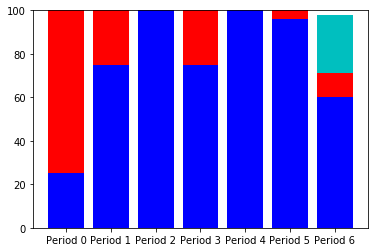

In [350]:
import numpy as np
import matplotlib.pyplot as plt

valeurs = period_relative
colours = ['b','g','r','c','m','y','k'] #to make sure colours remain the same throughout all slices

valeurs2 = dict()

for key in valeurs.keys():
    #print(key)
    key2 = "Period "+str(key)
    list_temp = list()
    for item in valeurs[key]:
        list_temp.append(int(item*100))   # let's have percentages and not .xx
    valeurs2[key2] = list_temp

    #for value in valeurs
    

for key,vals in valeurs2.items():
    print(key,vals)
    
    for i in range(0,len(vals)):        
        if i == 0:
            previous = 0
            plt.bar(x=key, height=vals[i],bottom=previous,color=colours[i])
            
        else:         
            previous = vals[i-1] + previous
            plt.bar(x=key, height=vals[i],bottom=previous,color=colours[i])
            
plt.xticks(range(len(valeurs2)), valeurs2.keys())

expert_image = s_senses.name.split("/")[-1]

#plt.figure(figsize=(20,10))
image = plt.gcf()
image.savefig(dir_out+"/"+expert_image+".png")
plt.show()


In [351]:
print(valeurs2.keys())

dict_keys(['Period 0', 'Period 1', 'Period 2', 'Period 3', 'Period 4', 'Period 5', 'Period 6'])


In [352]:
print(k_s_match)

for key,vals in valeurs2.items():
    print(key,vals)
    print(type(key),type(vals))
    for i in range(0,len(vals)):
        print("expert sense",i,"=",vals[i],"has the colour",colours[i])


{0: 0, 1: 1, 2: 3, 3: 2, 4: 1}
Period 0 [25, 0, 75, 0]
<class 'str'> <class 'list'>
expert sense 0 = 25 has the colour b
expert sense 1 = 0 has the colour g
expert sense 2 = 75 has the colour r
expert sense 3 = 0 has the colour c
Period 1 [75, 0, 25, 0]
<class 'str'> <class 'list'>
expert sense 0 = 75 has the colour b
expert sense 1 = 0 has the colour g
expert sense 2 = 25 has the colour r
expert sense 3 = 0 has the colour c
Period 2 [100, 0, 0, 0]
<class 'str'> <class 'list'>
expert sense 0 = 100 has the colour b
expert sense 1 = 0 has the colour g
expert sense 2 = 0 has the colour r
expert sense 3 = 0 has the colour c
Period 3 [75, 0, 25, 0]
<class 'str'> <class 'list'>
expert sense 0 = 75 has the colour b
expert sense 1 = 0 has the colour g
expert sense 2 = 25 has the colour r
expert sense 3 = 0 has the colour c
Period 4 [100, 0, 0, 0]
<class 'str'> <class 'list'>
expert sense 0 = 100 has the colour b
expert sense 1 = 0 has the colour g
expert sense 2 = 0 has the colour r
expert sen

liste_number_year = list() # creating a list because matplotlib wants a tuple
for key in sense_date_amount.keys():
    #print(key)
    liste_number_year.append(sense_date_amount[key])
    
tuple_number_year = tuple(liste_number_year)
#print(tuple_number_year)

period_number = dict()

for key in sense_date_amount.keys():
    compteur = 0
    if key[1] in range(0,number_of_slices):
        print(key,sense_date_amount[key[0],key[1]])
        compteur += sense_date_amount[key[0],key[1]]
        
        try :
            period_number[key[1]] += compteur
        except KeyError:
            period_number[key[1]] = 0
            period_number[key[1]] += compteur
            
        
for entry in period_number:
    print("période",entry,"number of uses",period_number[entry])


## Reading model output for plotting

In [353]:
lines_output_plot = output_senses.split("===============  per time  ===============")[1].split("\n")
period_relative_model = dict()


In [354]:
for i in range(0,len(lines_output_plot)):
    if lines_output_plot[i][0:5] == "Time=":  # if a line starts with "time" we take it into account
        for x in range(i,i+number_of_the_k+1): # for every "number of  the k" lines that follow
            #print(lines_output_plot[x])
            if lines_output_plot[x][0:5] == "Time=": # if a line starts with "time" we take the value for the slice
                period = lines_output_plot[x][5:6]
                templist = list()
                
            if lines_output_plot[x][0:5] != "Time=":  # if a line doesn't start with "time" but is considered(cf line3)
                ligne = re.split("\s{3,}",lines_output_plot[x]) # we take the first part of the line (importance of that K)
                templist.append(float(ligne[0]))
            #print(period,templist)
            
        period_relative_model[str(period)] = templist

In [355]:
print(period_relative_model)

{'0': [0.04083955068731151, 0.008486796949771783, 0.00597187964362235, 0.7697746391951782, 0.17492713352411612], '1': [0.10907371060119478, 0.014298730684103153, 0.03384641373162034, 0.5064813344844331, 0.3362998104986487], '2': [0.08757407290535785, 0.015051254608967434, 0.024163835560131568, 0.6984925663043847, 0.17471827062115847], '3': [0.07407106626171724, 0.03404926797763053, 0.04501432410891889, 0.6654202704667155, 0.18144507118501788], '4': [0.1803754795434305, 0.04005687932522156, 0.10369804638106733, 0.43394041107060427, 0.24192918367967622], '5': [0.17698941573659951, 0.03704265374613105, 0.14841983538917458, 0.41587711391800924, 0.2216709812100856], '6': [0.20603546151577476, 0.0777841384954993, 0.2523433469634035, 0.3203623104634722, 0.14347474256185028]}


## Plotting model output


Period 0 [0.04083955068731151, 0.008486796949771783, 0.00597187964362235, 0.7697746391951782, 0.17492713352411612]
<class 'str'> <class 'list'>
0 b
1 g
1 g
2 r
3 c
Period 1 [0.10907371060119478, 0.014298730684103153, 0.03384641373162034, 0.5064813344844331, 0.3362998104986487]
<class 'str'> <class 'list'>
0 b
1 g
1 g
2 r
3 c
Period 2 [0.08757407290535785, 0.015051254608967434, 0.024163835560131568, 0.6984925663043847, 0.17471827062115847]
<class 'str'> <class 'list'>
0 b
1 g
1 g
2 r
3 c
Period 3 [0.07407106626171724, 0.03404926797763053, 0.04501432410891889, 0.6654202704667155, 0.18144507118501788]
<class 'str'> <class 'list'>
0 b
1 g
1 g
2 r
3 c
Period 4 [0.1803754795434305, 0.04005687932522156, 0.10369804638106733, 0.43394041107060427, 0.24192918367967622]
<class 'str'> <class 'list'>
0 b
1 g
1 g
2 r
3 c
Period 5 [0.17698941573659951, 0.03704265374613105, 0.14841983538917458, 0.41587711391800924, 0.2216709812100856]
<class 'str'> <class 'list'>
0 b
1 g
1 g
2 r
3 c
Period 6 [0.2060354

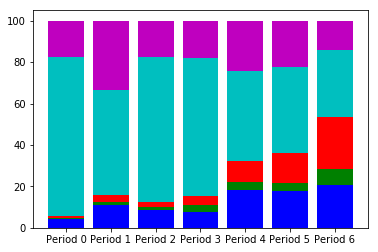

In [356]:
import numpy as np
import matplotlib.pyplot as plt

valeurs = period_relative_model
colours = ['b','g','r','c','m','y','k','w'] #to make sure colours remain the same throughout all slices


valeurs3 = dict()

for key in valeurs.keys():
    #print(key)
    key2 = "Period "+str(key)
    list_temp = list()
    for item in valeurs[key]:
        list_temp.append(item)   
    valeurs3[key2] = list_temp



for key,vals in valeurs3.items():
    print(key,vals)
    print(type(key),type(vals))
    
    for i in range(0,len(vals)):        
        if i == 0:
            previous = 0
            plt.bar(x=key, height=vals[i]*100,bottom=previous*100,color=colours[i])
            
        else:         
            previous = vals[i-1] + previous
            plt.bar(x=key, height=vals[i]*100,bottom=previous*100,color=colours[i])
            
        for value in k_s_match.values():
            if i == value: 
                print(i,colours[i])
        
plt.xticks(range(len(valeurs3)), valeurs3.keys())

#plt.figure(figsize=(20,10))

model_image = k_senses.name.split("/")[-1]

image = plt.gcf()
image.savefig(dir_out+"/"+model_image+".png")

plt.show()


In [331]:
print(k_s_match)

for key,vals in valeurs3.items():
    print(key,vals)
    #print(type(key),type(vals))
    for i in range(0,len(vals)):
        #print("model sense",i,"=",vals[i],"has the colour",colours[i])
        #print("this is the equivalent of")
        if k_s_match[i] != "NA":
            #print("expert sense",k_s_match[i],colours[int(k_s_match[i])],"\n")
            print(colours[i],"=====",colours[int(k_s_match[i])])
        else:
            print("NA\n")

{0: 0, 1: 1, 2: 3, 3: 2, 4: 1}
Period 0 [0.04083955068731151, 0.008486796949771783, 0.00597187964362235, 0.7697746391951782, 0.17492713352411612]
b ===== b
g ===== g
r ===== c
c ===== r
m ===== g
Period 1 [0.10907371060119478, 0.014298730684103153, 0.03384641373162034, 0.5064813344844331, 0.3362998104986487]
b ===== b
g ===== g
r ===== c
c ===== r
m ===== g
Period 2 [0.08757407290535785, 0.015051254608967434, 0.024163835560131568, 0.6984925663043847, 0.17471827062115847]
b ===== b
g ===== g
r ===== c
c ===== r
m ===== g
Period 3 [0.07407106626171724, 0.03404926797763053, 0.04501432410891889, 0.6654202704667155, 0.18144507118501788]
b ===== b
g ===== g
r ===== c
c ===== r
m ===== g
Period 4 [0.1803754795434305, 0.04005687932522156, 0.10369804638106733, 0.43394041107060427, 0.24192918367967622]
b ===== b
g ===== g
r ===== c
c ===== r
m ===== g
Period 5 [0.17698941573659951, 0.03704265374613105, 0.14841983538917458, 0.41587711391800924, 0.2216709812100856]
b ===== b
g ===== g
r ===== c
c 

## TODO:
1. ~~Choose best (k,s) pair~~
1. Match k and s in the plots
2. Label the plots (senses, slices)
2. ~~Remove the "w" sense~~
3. Confidence interval (less important for now)
4. ~~Fix the recall calculation cfr email Valerio 28/03~~
5. ~~CHECK PROBABILITIES (conf)~~ 
6. Write output to file + sync github
7. ~~Fix length of time interval (100 vs 113)_~~ ||| earliest date [from parameter_file] vs time interval

best pair: the one with the maximum above a certain threshold

## TODO post meeting with B and V
1. plot distribution of senses across genres
2. plot distribution of genres across time

## TODO post 10/4 3pm:

- ~~when parsing senses_3874965.txt, if mus-x is followed by something else than "1", mark the sense as "NA"~~
- ~~when parsing senses_3874965.txt, add a parameter for window size~~